# Importar bibliotecas

In [356]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import glob

import nltk 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, mean_squared_error

import re

import string

[nltk_data] Downloading package stopwords to /home/marcus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/marcus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/marcus/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Carregar Dados

In [357]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv",
                 encoding = 'ISO-8859-1',header=None)

In [358]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [359]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [360]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [361]:
df['sentiment'] = df['sentiment'].replace(4,1)

In [362]:
df['sentiment'].nunique()

2

In [363]:
df['sentiment'].unique()

array([0, 1])

<AxesSubplot: xlabel='sentiment', ylabel='count'>

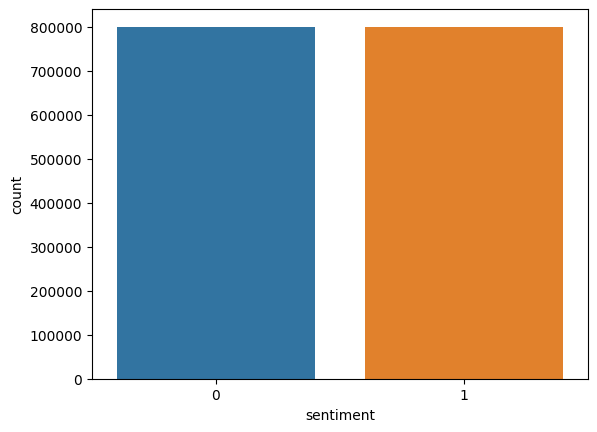

In [364]:
sns.countplot(x='sentiment', data=df)

# Pré-processamento

In [365]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [366]:
df['text']=df['text'].str.lower()
df['text'].tail()

1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, dtype: object

In [367]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['text'] = df['text'].apply(lambda text: cleaning_stopwords(text))
df['text'].head()

0    @switchfoot http://twitpic.com/2y1zl - awww, t...
1    upset can't update facebook texting it... migh...
2    @kenichan dived many times ball. managed save ...
3                     whole body feels itchy like fire
4    @nationwideclass no, it's not behaving all. i'...
Name: text, dtype: object

In [368]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df['text']= df['text'].apply(lambda x: cleaning_punctuations(x))
df['text'].tail()

1599995                  woke up no school best feeling ever
1599996    thewdbcom  cool hear old walt interviews â« h...
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, dtype: object

In [369]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x))
df['text'].tail()

1599995                    woke up no schol best feling ever
1599996    thewdbcom col hear old walt interviews â« htp...
1599997                      ready mojo makeover ask details
1599998     hapy 38th birthday bo al time tupac amaru shakur
1599999    hapy charitytuesday thenspc sparkscharity spea...
Name: text, dtype: object

In [370]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df['text'] = df['text'].apply(lambda x: cleaning_URLs(x))
df['text'].tail()

1599995                    woke up no schol best feling ever
1599996    thewdbcom col hear old walt interviews â« htp...
1599997                      ready mojo makeover ask details
1599998     hapy 38th birthday bo al time tupac amaru shakur
1599999    hapy charitytuesday thenspc sparkscharity spea...
Name: text, dtype: object

In [371]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df['text'] = df['text'].apply(lambda x: cleaning_numbers(x))
df['text'].tail()

1599995                    woke up no schol best feling ever
1599996    thewdbcom col hear old walt interviews â« htp...
1599997                      ready mojo makeover ask details
1599998       hapy th birthday bo al time tupac amaru shakur
1599999    hapy charitytuesday thenspc sparkscharity spea...
Name: text, dtype: object

In [372]:
tokenizer = RegexpTokenizer(r'\w+')
df['text'] = df['text'].apply(tokenizer.tokenize)
df['text'].head()

0    [switchfot, htptwitpicomyzl, aw, thats, bumer,...
1    [upset, cant, update, facebok, texting, it, mi...
2    [kenichan, dived, many, times, bal, managed, s...
3               [whole, body, fels, itchy, like, fire]
4    [nationwideclas, no, its, not, behaving, al, i...
Name: text, dtype: object

In [373]:
st = nltk.PorterStemmer()
def stemming_on_text(df):
    text = [st.stem(word) for word in df]
    return df
df['text']= df['text'].apply(lambda x: stemming_on_text(x))
df['text'].head()

0    [switchfot, htptwitpicomyzl, aw, thats, bumer,...
1    [upset, cant, update, facebok, texting, it, mi...
2    [kenichan, dived, many, times, bal, managed, s...
3               [whole, body, fels, itchy, like, fire]
4    [nationwideclas, no, its, not, behaving, al, i...
Name: text, dtype: object

In [374]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
df['text'] = df['text'].apply(lambda x: lemmatizer_on_text(x))
df['text'].head()

0    [switchfot, htptwitpicomyzl, aw, thats, bumer,...
1    [upset, cant, update, facebok, texting, it, mi...
2    [kenichan, dived, many, times, bal, managed, s...
3               [whole, body, fels, itchy, like, fire]
4    [nationwideclas, no, its, not, behaving, al, i...
Name: text, dtype: object

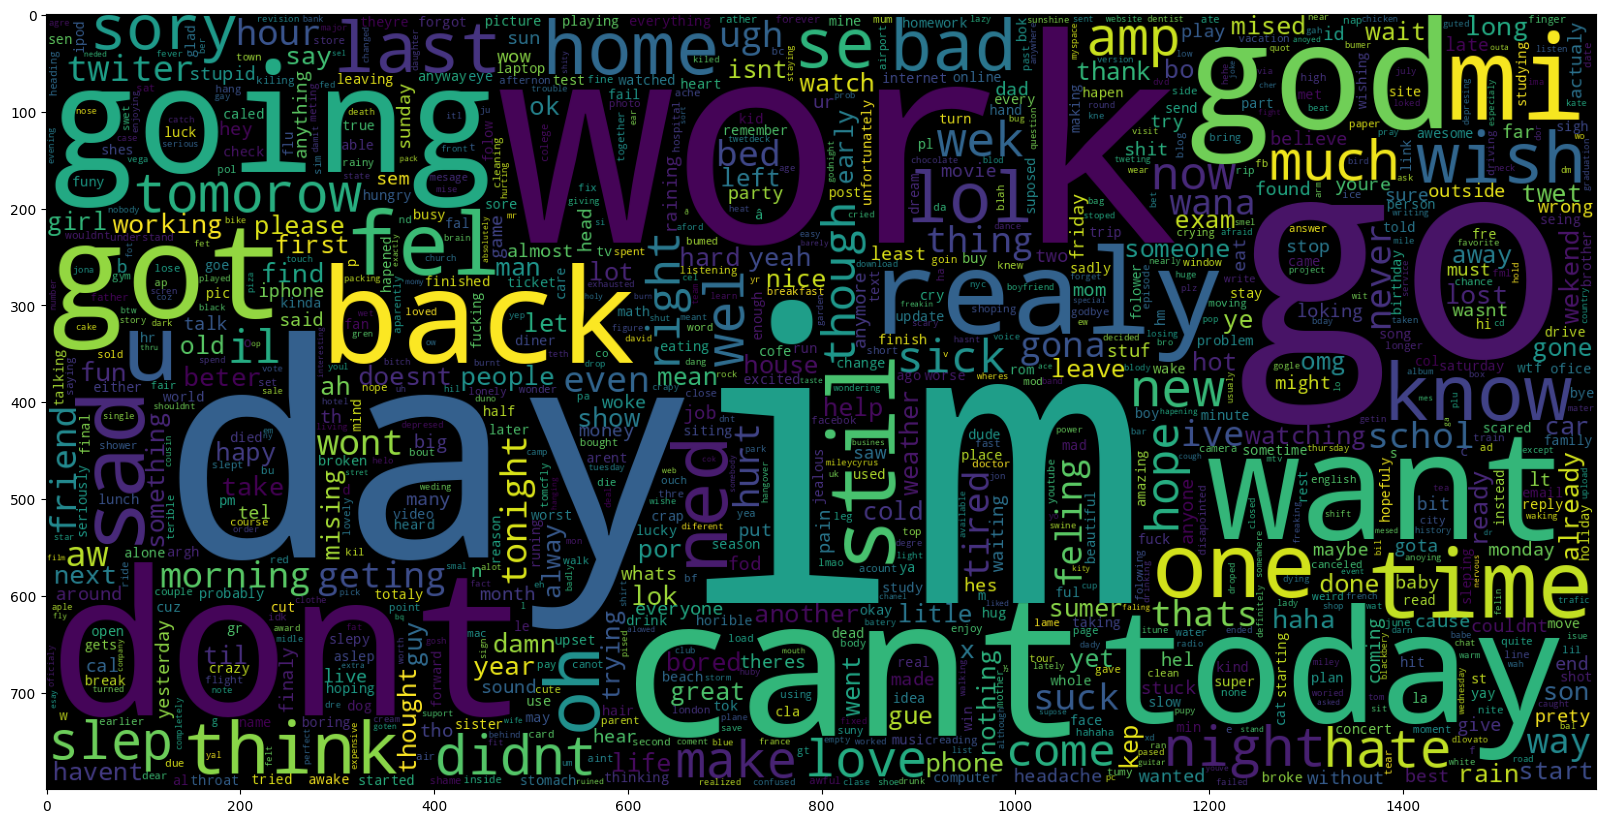

In [375]:

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(' '.join(' '.join(l) for l in df[df.sentiment==0].text))
plt.imshow(wc)

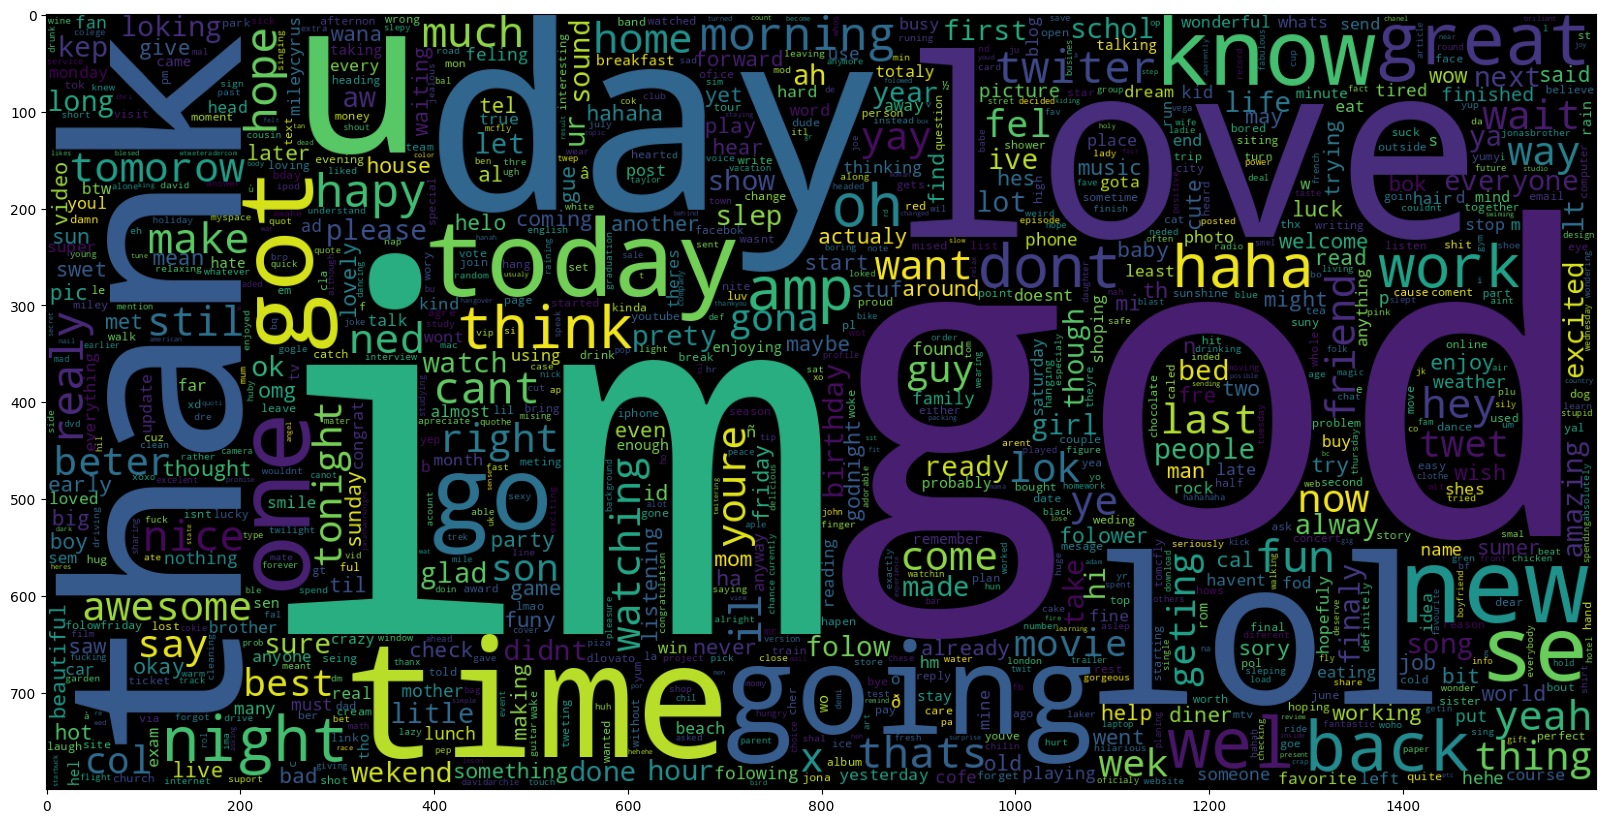

In [376]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(' '.join(' '.join(l) for l in df[df.sentiment==1].text))
plt.imshow(wc)

In [377]:
X=df.text
y=df.sentiment

In [378]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =26105111)

In [379]:
print(X_train)

477257                                         [rachele, no]
555718     [grizlovesyou, yup, busy, colecting, stones, l...
964030     [dazleme, thats, great, idea, hm, anop, cupcak...
1023468    [mateoamarei, hmph, even, though, stil, punish...
160610                 [canot, slep, hours, tosing, turning]
                                 ...                        
724937                [niga, wana, go, homeaint, home, days]
1201868                             [watching, hockey, game]
521390     [anyone, contacts, people, uni, nevada, las, v...
974580                     [amazing, night, amazing, person]
18431      [hope, cal, day, amp, picnic, day, davis, not,...
Name: text, Length: 1280000, dtype: object


In [380]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train.apply(lambda x: ' '.join(x)))
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000


/home/marcus/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [381]:
X_train = vectoriser.transform(X_train.apply(lambda x: ' '.join(x)))
X_test  = vectoriser.transform(X_test.apply(lambda x: ' '.join(x)))
X = vectoriser.transform(X.apply(lambda x: ' '.join(x)))

# Treinar e Testar modelos

In [382]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Modelo de Bernoulli Naive Bayes

              precision    recall  f1-score   support

           0       0.81      0.78      0.79    159838
           1       0.79      0.81      0.80    160162

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



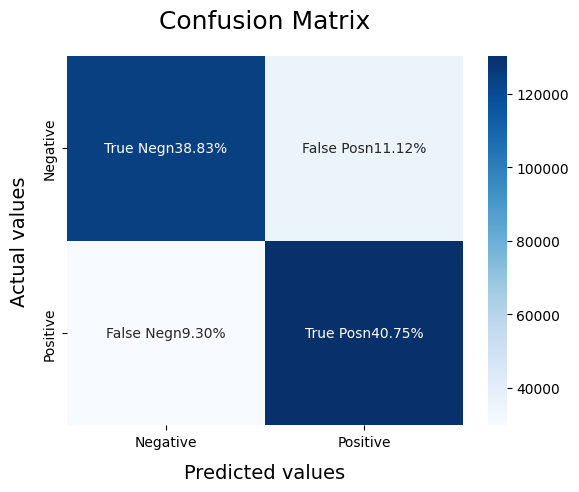

In [383]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

In [384]:
print("Erro quadrático médio: {}".format(mean_squared_error(y_test, y_pred1)))

Erro quadrático médio: 0.204134375


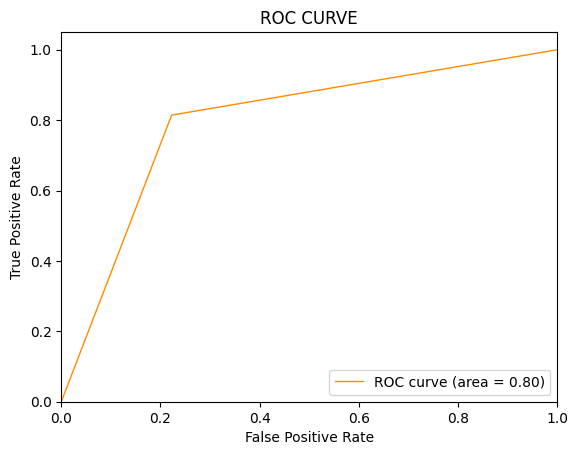

In [385]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Modelo Linear support Vector Classification (Linear SVC)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80    159838
           1       0.80      0.81      0.80    160162

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



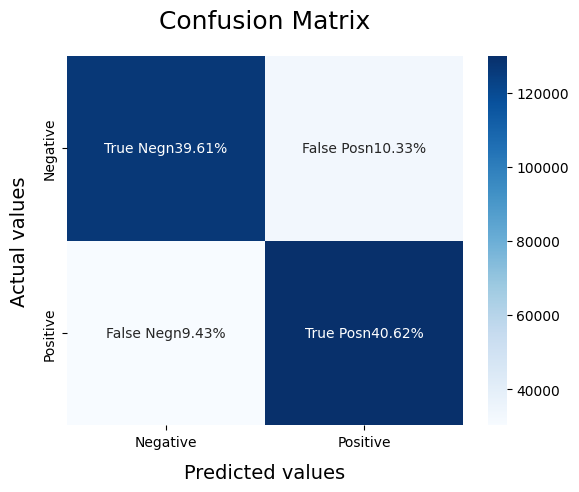

In [386]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

In [387]:
print("Erro quadrático médio: {}".format(mean_squared_error(y_test, y_pred2)))

Erro quadrático médio: 0.197665625


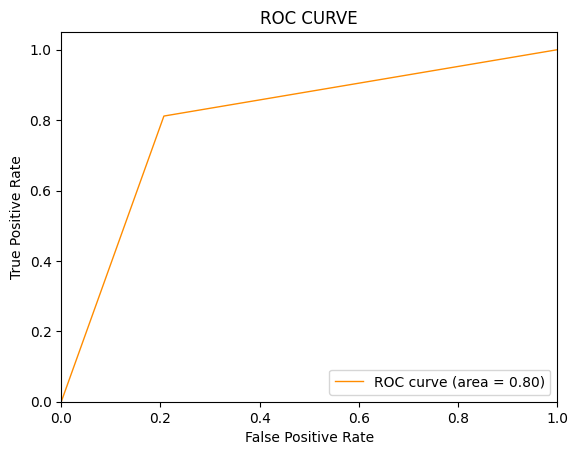

In [388]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Modelo logistic Regression

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    159838
           1       0.81      0.82      0.82    160162

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



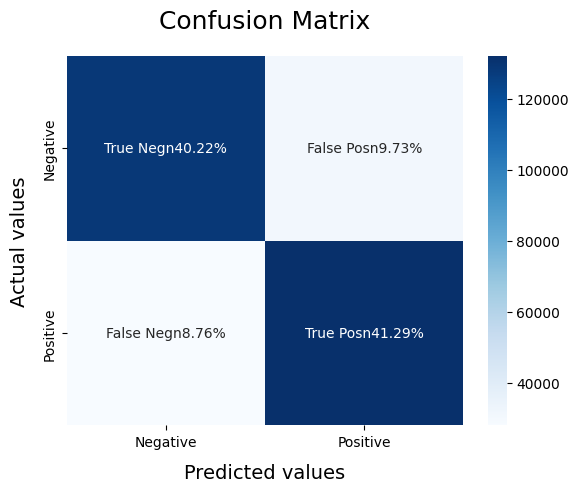

In [389]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

In [390]:
print("Erro quadrático médio: {}".format(mean_squared_error(y_test, y_pred3)))

Erro quadrático médio: 0.184921875


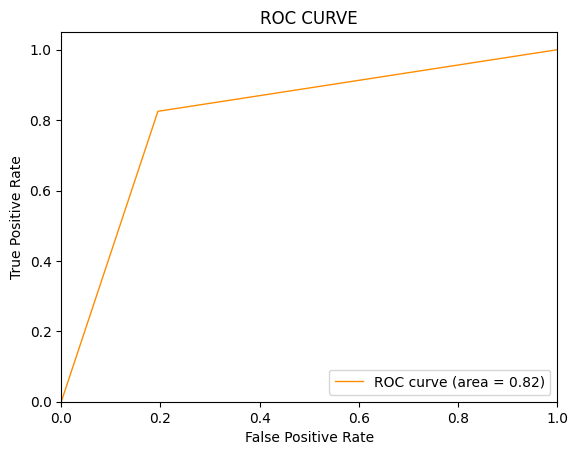

In [391]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

## Modelo Multinomial Naive Bayes

              precision    recall  f1-score   support

           0       0.79      0.81      0.80    159838
           1       0.81      0.79      0.80    160162

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



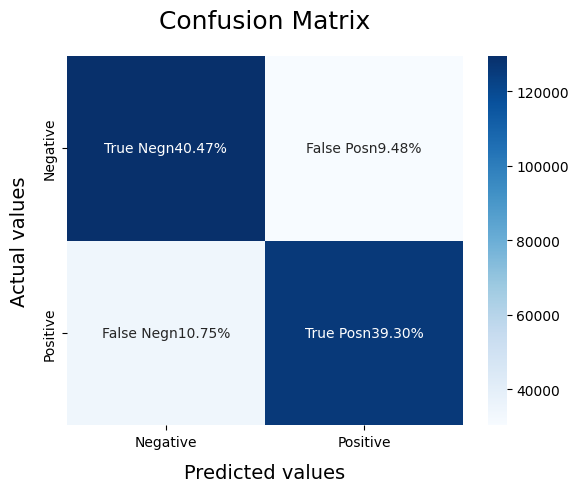

In [392]:
MNBmodel = MultinomialNB()
MNBmodel.fit(X_train, y_train)
model_Evaluate(MNBmodel)
y_pred4 = MNBmodel.predict(X_test)

In [393]:
print("Erro quadrático médio: {}".format(mean_squared_error(y_test, y_pred4)))

Erro quadrático médio: 0.202328125


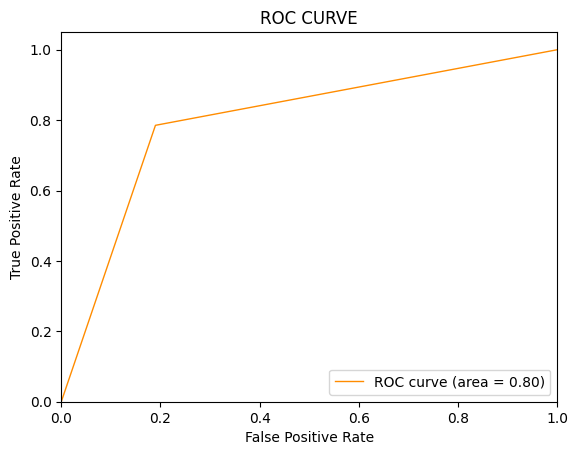

In [425]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred4)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# Classificação dos tweets da eleição

In [395]:
files = glob.glob("./translated_dataset/*.csv")

df_candidatos = pd.DataFrame()
for f in files:
    csv = pd.read_csv(f)
    df_candidatos = df_candidatos.append(csv)


/tmp/ipykernel_842/1112167517.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_candidatos = df_candidatos.append(csv)
/tmp/ipykernel_842/1112167517.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_candidatos = df_candidatos.append(csv)
/tmp/ipykernel_842/1112167517.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_candidatos = df_candidatos.append(csv)
/tmp/ipykernel_842/1112167517.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_candidatos = df_candidatos.append(csv)
/tmp/ipykernel_842/1112167517.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

In [396]:

df_candidatos = df_candidatos.loc[:, ~df_candidatos.columns.isin(['ID', 'User',  'Time', 'Hashtags', 'User_ID', 'Created_at', 'Verified', 'Emoji', 'Followers_Count','Retweet_count', 'Created_at','Favorite_count'])]
df_candidatos.head(10)

,Tweet,Candidato
0,no one can judge people gave up voting right s...,[]
1,let people vote,[]
2,god squid god northeast side love save,['Lula']
3,extended voting schedule prison director prf e...,[]
4,pls lula,['Lula']
5,portals doctor strange make way facilitate vot...,[]
6,let the northeast vote let the northeast vote,[]
7,let northeast vote,[]
8,ooo well you're going to fucking win let's fac...,['Bolsonaro']
9,vote today old current school principal math t...,[]


In [397]:
df_candidatos.drop(df_candidatos[ df_candidatos['Candidato'] == "[]"].index, inplace = True)

<AxesSubplot: xlabel='Candidato', ylabel='count'>

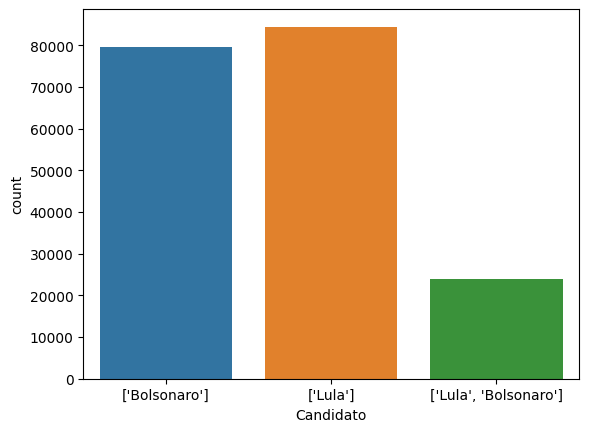

In [398]:
sns.countplot(x='Candidato', data=df_candidatos)

In [399]:
df_candidatos['Tweet']=df_candidatos['Tweet'].str.lower()
df_candidatos['Tweet'].tail()

59236                   simone people massacring bolsonaro
59240                                        bolsonaro won
59241    come hahaha simone laying down bolsonaro beati...
59242                bolsonaro being disgusting ass always
59243    think i think lula received some feedback for ...
Name: Tweet, dtype: object

In [400]:
df_candidatos['Tweet'] = df_candidatos['Tweet'].apply(lambda text: cleaning_stopwords(text))
df_candidatos['Tweet'].head()

20       seeing posts right vote 22 bolsonaroreeleito22
25            squid second round elections 2022 bpmoney
30                 let northeast vote lula presidente13
33    squid going next president against everything ...
34    censor jp news mistake hit ignore denounces bo...
Name: Tweet, dtype: object

In [401]:
df_candidatos['Tweet']= df_candidatos['Tweet'].apply(lambda x: cleaning_punctuations(x))
df_candidatos['Tweet'].tail()

59236                   simone people massacring bolsonaro
59240                                            bolsonaro
59241    come hahaha simone laying bolsonaro beating ne...
59242                      bolsonaro disgusting ass always
59243    think think lula received feedback purpose pro...
Name: Tweet, dtype: object

In [402]:
df_candidatos['Tweet'] = df_candidatos['Tweet'].apply(lambda x: cleaning_repeating_char(x))
df_candidatos['Tweet'].tail()

59236                    simone people masacring bolsonaro
59240                                            bolsonaro
59241    come hahaha simone laying bolsonaro beating ne...
59242                       bolsonaro disgusting as always
59243    think think lula received fedback purpose prob...
Name: Tweet, dtype: object

In [403]:
df_candidatos['Tweet'] = df_candidatos['Tweet'].apply(lambda x: cleaning_URLs(x))
df_candidatos['Tweet'].tail()

59236                    simone people masacring bolsonaro
59240                                            bolsonaro
59241    come hahaha simone laying bolsonaro beating ne...
59242                       bolsonaro disgusting as always
59243    think think lula received fedback purpose prob...
Name: Tweet, dtype: object

In [404]:
df_candidatos['Tweet'] = df_candidatos['Tweet'].apply(lambda x: cleaning_numbers(x))
df_candidatos['Tweet'].tail()


59236                    simone people masacring bolsonaro
59240                                            bolsonaro
59241    come hahaha simone laying bolsonaro beating ne...
59242                       bolsonaro disgusting as always
59243    think think lula received fedback purpose prob...
Name: Tweet, dtype: object

In [405]:
df_candidatos['Tweet'] = df_candidatos['Tweet'].apply(tokenizer.tokenize)
df_candidatos['Tweet'].head()

20        [seing, posts, right, vote, bolsonaroreleito]
25           [squid, second, round, elections, bpmoney]
30             [let, northeast, vote, lula, presidente]
33    [squid, going, next, president, against, every...
34    [censor, jp, news, mistake, hit, ignore, denou...
Name: Tweet, dtype: object

In [406]:
df_candidatos['Tweet']= df_candidatos['Tweet'].apply(lambda x: stemming_on_text(x))
df_candidatos['Tweet'].head()

20        [seing, posts, right, vote, bolsonaroreleito]
25           [squid, second, round, elections, bpmoney]
30             [let, northeast, vote, lula, presidente]
33    [squid, going, next, president, against, every...
34    [censor, jp, news, mistake, hit, ignore, denou...
Name: Tweet, dtype: object

In [407]:
df_candidatos['Tweet'] = df_candidatos['Tweet'].apply(lambda x: lemmatizer_on_text(x))
df_candidatos['Tweet'].head()

20        [seing, posts, right, vote, bolsonaroreleito]
25           [squid, second, round, elections, bpmoney]
30             [let, northeast, vote, lula, presidente]
33    [squid, going, next, president, against, every...
34    [censor, jp, news, mistake, hit, ignore, denou...
Name: Tweet, dtype: object

In [408]:
X_candidatos = df_candidatos.Tweet
Y_candidatos = df_candidatos.Candidato

In [409]:
print(Y_candidatos)

20       ['Bolsonaro']
25            ['Lula']
30            ['Lula']
33            ['Lula']
34       ['Bolsonaro']
             ...      
59236    ['Bolsonaro']
59240    ['Bolsonaro']
59241    ['Bolsonaro']
59242    ['Bolsonaro']
59243         ['Lula']
Name: Candidato, Length: 187967, dtype: object


In [410]:
vectoriser.fit(X_candidatos.apply(lambda x: ' '.join(x)))
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000


/home/marcus/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [411]:
X_candidatos = vectoriser.transform(X_candidatos.apply(lambda x: ' '.join(x)))

In [412]:
y_pred_cand = LRmodel.predict(X_candidatos)
print(y_pred_cand)

[1 1 1 ... 0 1 0]


In [413]:
lula_pos = 0
lula_neg = 0
bolso_pos = 0
bolso_neg = 0
i=0;
for cand in Y_candidatos:

    if(cand == "['Lula']"):
        if(y_pred_cand[i] == 1):
            lula_pos += 1
        else:
            lula_neg += 1
    elif(cand == "['Bolsonaro']"):
        if(y_pred_cand[i] == 1):
            bolso_pos += 1
        else:
            bolso_neg += 1
    i+=1

print("Lula => aprovação: {}".format(lula_pos/(lula_pos+lula_neg)))
print("Bolsonaro => aprovação: {}".format(bolso_pos/(bolso_pos+bolso_neg)))

Lula => aprovação: 0.8370374755787106
Bolsonaro => aprovação: 0.8584139751162498


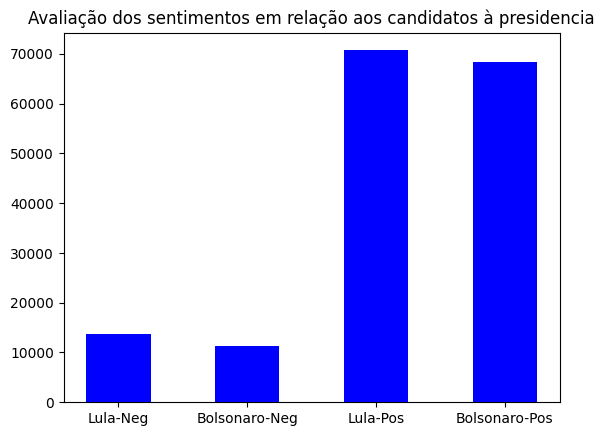

In [414]:
president = ["Lula-Neg", "Bolsonaro-Neg", "Lula-Pos", "Bolsonaro-Pos"]
valores = [lula_neg, bolso_neg, lula_pos, bolso_pos]

plt.bar(president, valores, color='blue', width=0.5)

plt.title("Avaliação dos sentimentos em relação aos candidatos à presidencia")
plt.show()

In [415]:
y_pred_cand = SVCmodel.predict(X_candidatos)
print(y_pred_cand)

[1 1 1 ... 0 1 0]


In [416]:
lula_pos = 0
lula_neg = 0
bolso_pos = 0
bolso_neg = 0
i=0;
for cand in Y_candidatos:

    if(cand == "['Lula']"):
        if(y_pred_cand[i] == 1):
            lula_pos += 1
        else:
            lula_neg += 1
    elif(cand == "['Bolsonaro']"):
        if(y_pred_cand[i] == 1):
            bolso_pos += 1
        else:
            bolso_neg += 1
    i+=1

print("Lula => aprovação: {}".format(lula_pos/(lula_pos+lula_neg)))
print("Bolsonaro => aprovação: {}".format(bolso_pos/(bolso_pos+bolso_neg)))

Lula => aprovação: 0.6477295601207744
Bolsonaro => aprovação: 0.6886012316199572


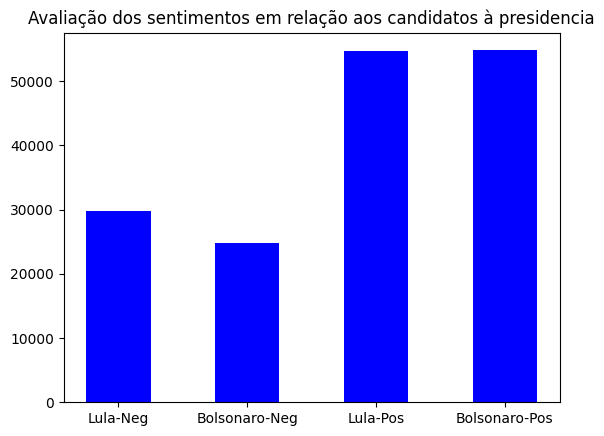

In [417]:
president = ["Lula-Neg", "Bolsonaro-Neg", "Lula-Pos", "Bolsonaro-Pos"]
valores = [lula_neg, bolso_neg, lula_pos, bolso_pos]

plt.bar(president, valores, color='blue', width=0.5)

plt.title("Avaliação dos sentimentos em relação aos candidatos à presidencia")
plt.show()

In [418]:
y_pred_cand = BNBmodel.predict(X_candidatos)
print(y_pred_cand)

[1 0 1 ... 1 1 1]


In [419]:
lula_pos = 0
lula_neg = 0
bolso_pos = 0
bolso_neg = 0
i=0;
for cand in Y_candidatos:

    if(cand == "['Lula']"):
        if(y_pred_cand[i] == 1):
            lula_pos += 1
        else:
            lula_neg += 1
    elif(cand == "['Bolsonaro']"):
        if(y_pred_cand[i] == 1):
            bolso_pos += 1
        else:
            bolso_neg += 1
    i+=1

print("Lula => aprovação: {}".format(lula_pos/(lula_pos+lula_neg)))
print("Bolsonaro => aprovação: {}".format(bolso_pos/(bolso_pos+bolso_neg)))

Lula => aprovação: 0.7244449706944527
Bolsonaro => aprovação: 0.6511122282267187


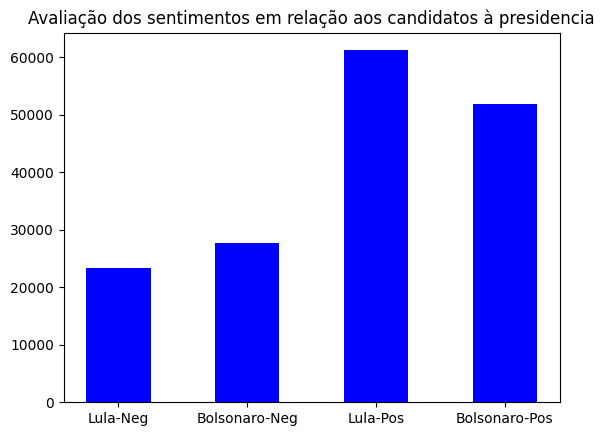

In [420]:
president = ["Lula-Neg", "Bolsonaro-Neg", "Lula-Pos", "Bolsonaro-Pos"]
valores = [lula_neg, bolso_neg, lula_pos, bolso_pos]

plt.bar(president, valores, color='blue', width=0.5)

plt.title("Avaliação dos sentimentos em relação aos candidatos à presidencia")
plt.show()

In [421]:
y_pred_cand = MNBmodel.predict(X_candidatos)
print(y_pred_cand)

[1 0 1 ... 0 0 1]


In [422]:
lula_pos = 0
lula_neg = 0
bolso_pos = 0
bolso_neg = 0
i=0;
for cand in Y_candidatos:

    if(cand == "['Lula']"):
        if(y_pred_cand[i] == 1):
            lula_pos += 1
        else:
            lula_neg += 1
    elif(cand == "['Bolsonaro']"):
        if(y_pred_cand[i] == 1):
            bolso_pos += 1
        else:
            bolso_neg += 1
    i+=1

print("Lula => aprovação: {}".format(lula_pos/(lula_pos+lula_neg)))
print("Bolsonaro => aprovação: {}".format(bolso_pos/(bolso_pos+bolso_neg)))

Lula => aprovação: 0.6019892250310817
Bolsonaro => aprovação: 0.6134724142264673


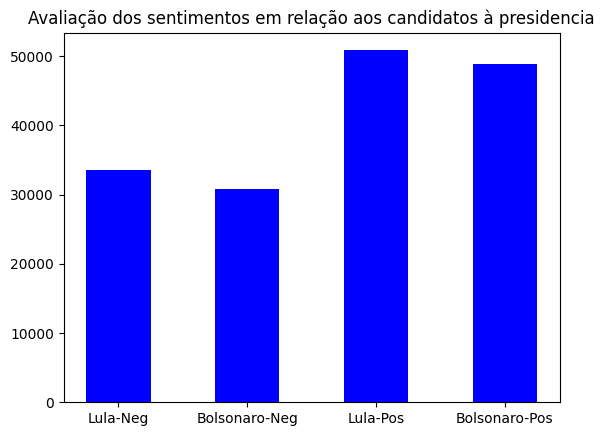

In [423]:
president = ["Lula-Neg", "Bolsonaro-Neg", "Lula-Pos", "Bolsonaro-Pos"]
valores = [lula_neg, bolso_neg, lula_pos, bolso_pos]

plt.bar(president, valores, color='blue', width=0.5)

plt.title("Avaliação dos sentimentos em relação aos candidatos à presidencia")
plt.show()